In [1]:
import haiku as hk
import jax
import jax.random as jrnd
import jax.numpy as jnp

import numpy as np
import optax

In [2]:
from modules import *
from utils import *
from training import *

In [3]:
import matplotlib.pyplot as plt

# Dataset

In [4]:
#disable tensorflow from accessing the GPU - it is only processing the dataset
disable_gpu_tf()

In [5]:
#choose standard dataset here - e.g. MNIST, Fashion MNIST, Kuzushiji MNIST
dataset = "fashion_mnist"

In [6]:
#load the dataset
n_batch = 128
train, x_train, y_train = load_dataset(dataset, split="train", is_training=True, batch_size=n_batch)

In [7]:
n_train = x_train.shape[0]
x_train.shape

(60000, 28, 28, 1)

# Model

In [8]:
# Define a residual block module

class Residual_AE(hk.Module):
    def __init__(self, widening_factor: int = 2, dim_vsa: int = 1024, name=None):
        super().__init__(name=name)
        self.n_hidden = dim_vsa * widening_factor
        self.dim_vsa = dim_vsa
        
    def __call__(self, x):
        input_ = x
        
        #hidden layer
        x = conv_1d(self.n_hidden)(x)
        #output layer
        x = conv_1d(self.dim_vsa)(x)
        
        #residual binding
        y = bind_list(input_, x)
        
        return y

In [9]:
def resnet12(x, 
           is_training: bool = False,
           var_scaling = 1.0, 
           vsa_dimension = 1024,
           codebook_sparsity: float = 0.75):
    
    x = scale_mnist(x)
    #project into VSA
    x = ProjectAll(vsa_dimension)(x)
    x = layer_norm(x)
    
    wf_block1 = 2
    x = Residual_AE(wf_block1, vsa_dimension)(x)
    x = Residual_AE(wf_block1, vsa_dimension)(x)
    x = Residual_AE(wf_block1, vsa_dimension)(x)
    x = Residual_AE(wf_block1, vsa_dimension)(x)
    
    wf_block2 = 2
    x = Residual_AE(wf_block2, vsa_dimension)(x)
    x = Residual_AE(wf_block2, vsa_dimension)(x)
    x = Residual_AE(wf_block2, vsa_dimension)(x)
    x = Residual_AE(wf_block2, vsa_dimension)(x)
    
    wf_block3 = 2
    x = Residual_AE(wf_block3, vsa_dimension)(x)
    x = Residual_AE(wf_block3, vsa_dimension)(x)
    x = Residual_AE(wf_block3, vsa_dimension)(x)
    x = Residual_AE(wf_block3, vsa_dimension)(x)
   
    x = CodebookDecoder(10, vsa_dimension, sparsity = codebook_sparsity)(x)
     
    return x

In [10]:
#declare the model as a transformation
model = hk.transform(resnet12)

In [11]:
#instantiate the first PRNG key
key = jrnd.PRNGKey(42)

In [12]:
#split the key and use it to create the model's initial parameters
key, subkey = jrnd.split(key)
params = model.init(subkey, x_train[0:10,...])

In [13]:
#create an instance of the RMSprop optimizer
opt = optax.rmsprop(0.001)

In [14]:
#get a sample batch from the train set
b = next(train)
x = b['image']
y = b['label']

b x y c ->  (128, 28, 28, 1)


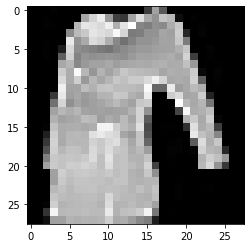

In [15]:
print("b x y c -> ", x.shape)
plt.imshow(x[0,...], cmap="gray");

Text(0, 0.5, 'Density')

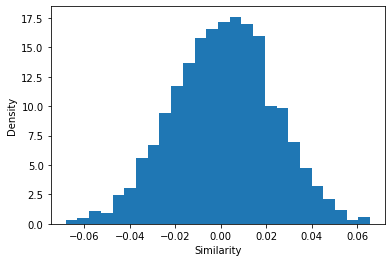

In [16]:
#sample the initial similarities the model produces between an 
# image and the class codebook. 

sim = model.apply(params, key, x, is_training=True)

plt.hist(np.array(sim.ravel()), bins=26, density=True)
plt.xlabel("Similarity")
plt.ylabel("Density")

Text(0.5, 1.0, 'Pre-Train Similarity')

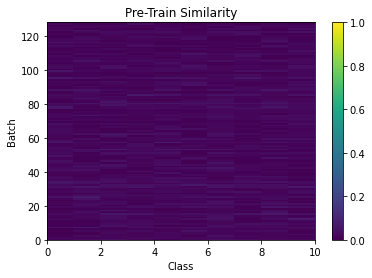

In [17]:
#Visualize the similarity each sample produces to the class codebook
plt.pcolor(jnp.abs(sim), vmax=1.0, vmin=0.0)
plt.xlabel("Class")
plt.ylabel("Batch")
plt.colorbar()
plt.title("Pre-Train Similarity")

In [18]:
# Compute a sample of the loss function over these similarities. 
# Takes the complement of the similarity for the correct class label.
# This value (distance) will be minimized over training.

jnp.mean(onehot_loss(sim, y))

DeviceArray(0.9970922, dtype=float32)

# Training

In [19]:
params_t, losses = train_model(model, 
                               key, 
                               params = params, 
                               dataset = train, 
                               optimizer = opt, 
                               loss_fn = onehot_loss, 
                               batches = 2000)

100%|█████████████████████████████████████████████████| 2000/2000 [11:41<00:00,  2.85it/s]


Text(0, 0.5, 'Loss')

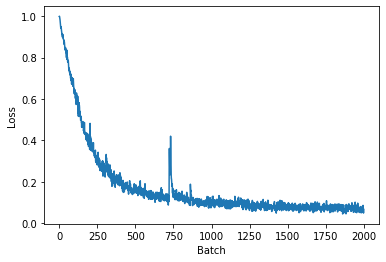

In [20]:
#Plot the history of the loss values over batches
plt.plot(losses)
plt.xlabel("Batch")
plt.ylabel("Loss")

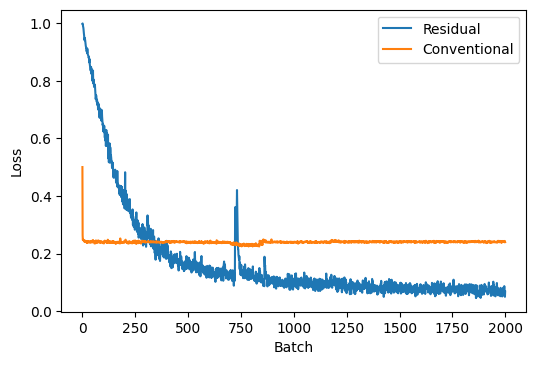

In [21]:
#load and plot the results from the non-residual deep network for comparison
losses_nonresidual = np.load("ae_losses.npz")['loss']

plt.figure(dpi=100)
plt.plot(losses, label="Residual")
plt.plot(losses_nonresidual, label="Conventional")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()

# Test

In [23]:
#Load the testing dataset
test, x_test, y_test = load_dataset(dataset, split="test", is_training=False, repeat = False, batch_size=n_batch)

In [24]:
#Load a non-repeating copy of the training dataset
train2, _, _ = load_dataset(dataset, split="train", is_training=False, repeat = False, batch_size=n_batch)

In [25]:
#define a labmda to compute accuracy we can dispatch over batches
acc_fn = lambda b: accuracy(model, key, params_t, b['image'], b['label'])

In [26]:
#compute the test set accuracy
preds = jnp.concatenate([acc_fn(b) for b in test])
print("Test set accuracy is ", jnp.mean(preds))

Test set accuracy is  0.8559


In [27]:
#compute train set accuracy
preds_t = jnp.concatenate([acc_fn(b) for b in train2])
print("Train set accuracy is ", jnp.mean(preds_t))

Train set accuracy is  0.88451666


Text(0.5, 1.0, 'Post-Train Similarity')

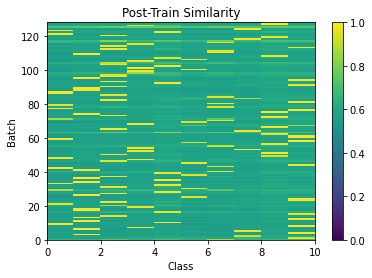

In [28]:
#Visualize the similarity each sample produces to the class codebook
sim2 = model.apply(params_t, key, x)

plt.pcolor(sim2, vmax=1.0, vmin=0.0)
plt.xlabel("Class")
plt.ylabel("Batch")
plt.colorbar()
plt.title("Post-Train Similarity")